In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, KFold
import collections
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.metrics import accuracy_score,mean_squared_error,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model, preprocessing
import statsmodels.api as sm
from sklearn import tree, metrics
%matplotlib inline

In [2]:
#Read in csv file
file = 'takehome_users.csv'
data = pd.read_csv(file,encoding = "ISO-8859-1")
df_user = pd.DataFrame(data)
file = 'takehome_user_engagement.csv'
data = pd.read_csv(file)
df_eng = pd.DataFrame(data)
print(df_user.head(5))
print(df_eng.head(5))

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

first thing is to define 'adopted user' who has logged into the product on three separate days in at least one seven day period

In [3]:
np.bincount(df_eng['user_id'].unique())

array([0, 1, 1, ..., 1, 1, 1])

In [4]:
df_eng['time_stamp']= pd.to_datetime(df_eng['time_stamp'])
df_eng.set_index('time_stamp')

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
...,...,...
2013-09-06 06:14:15,11996,1
2013-01-15 18:28:37,11997,1
2014-04-27 12:45:16,11998,1


In [5]:
# group time_stamp to be the unit of week.
df_engupd = df_eng.groupby([pd.Grouper(key = 'time_stamp', freq='W'),'user_id']).sum()

In [6]:
df_engupd.head(5)

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1

In [7]:
df_adp = df_engupd[df_engupd['visited']>=3]

In [8]:
df_adp = df_adp.reset_index('user_id')
adopted_user = df_adp['user_id'].to_numpy()

In [9]:
df_user2 = df_user

In [10]:
df_user2['adopted']=0

In [11]:
for i in range(len(adopted_user)):
    df_user2.iloc[adopted_user[i], 10]=1
df_user2

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


### Data Cleaning

In [12]:
df_user2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


there are 2 columns have null values, need to be fixed first.
'last_session_creation_time' will be filled by the average value 
'invited_by_user_id' will be filled with 0

In [13]:
df_user2['last_session_creation_time']= df_user2['last_session_creation_time'].fillna(np.mean(df_user2['last_session_creation_time']))

In [14]:
df_user2['invited_by_user_id']= df_user2['invited_by_user_id'].fillna(0)

In [15]:
df_user2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Next thing is to convert data type.
1. creation_time convert to datetime
2. name is unique value for each user, will drop this variable
3. same as 'name', email is also unique value for each user, won't count it for analysis
4. creation_source -- will check how many different sources are defined.

In [16]:
# creation time
df_user2['creation_time']=pd.to_datetime(df_user2['creation_time'])

In [17]:
df_user2['creation_time_month']=df_user2['creation_time'].dt.month
df_user2['creation_time_year']=df_user2['creation_time'].dt.year
df_user2['creation_time_week']=df_user2['creation_time'].dt.week
df_user2['creation_time_dayweek']=df_user2['creation_time'].dt.dayofweek

In [18]:
# creation time
df_user2['last_session_creation_time']=pd.to_datetime(df_user2['last_session_creation_time'], unit = 's')

In [19]:
df_user2['signup_length']=df_user2['last_session_creation_time']-df_user2['creation_time']
df_user2['signup_length']=df_user2['signup_length'].dt.days

In [20]:
df_user2['last_session_creation_time_month']=df_user2['last_session_creation_time'].dt.month
df_user2['last_session_creation_time_year']=df_user2['last_session_creation_time'].dt.year
df_user2['last_session_creation_time_week']=df_user2['last_session_creation_time'].dt.week
df_user2['last_session_creation_time_dayweek']=df_user2['last_session_creation_time'].dt.dayofweek

In [21]:
df_user2['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [22]:
one_hot = pd.get_dummies(df_user2['creation_source'])
# Drop column as it is now encoded
df = df_user2.join(one_hot)
df 

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,signup_length,last_session_creation_time_month,last_session_creation_time_year,last_session_creation_time_week,last_session_creation_time_dayweek,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,0,4,2014,17,1,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,136,3,2014,14,0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,...,0,3,2013,12,1,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,...,1,5,2013,21,2,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,...,5,1,2013,4,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,...,0,9,2013,36,4,0,1,0,0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0.0,...,5,1,2013,3,1,0,0,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,...,0,4,2014,17,6,1,0,0,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,0.0,...,2,6,2012,22,5,0,0,1,0,0


In [23]:
df = df.drop(['object_id','creation_time', 'name','email','creation_source'], axis =1)

In [24]:
df = df.drop(['last_session_creation_time'], axis =1)

In [25]:
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_time_month,creation_time_year,creation_time_week,creation_time_dayweek,signup_length,last_session_creation_time_month,last_session_creation_time_year,last_session_creation_time_week,last_session_creation_time_dayweek,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,4,2014,17,1,0,4,2014,17,1,1,0,0,0,0
1,0,0,1,316.0,0,11,2013,46,4,136,3,2014,14,0,0,1,0,0,0
2,0,0,94,1525.0,1,3,2013,12,1,0,3,2013,12,1,0,1,0,0,0
3,0,0,1,5151.0,0,5,2013,21,1,1,5,2013,21,2,1,0,0,0,0
4,0,0,193,5240.0,0,1,2013,3,3,5,1,2013,4,1,1,0,0,0,0


### Modeling

After we defined adopted user and merged the adopted user list into the dataframe, we need to build classification models to identify which factors predict future user adoption.

Feature:            opted_in_to_mailing_list, Score: -0.00009
Feature:          enabled_for_marketing_drip, Score: 0.00030
Feature:                              org_id, Score: 0.00000
Feature:                  invited_by_user_id, Score: -0.00000
Feature:                             adopted, Score: -0.00042
Feature:                 creation_time_month, Score: -0.00045
Feature:                  creation_time_year, Score: -0.00450
Feature:                  creation_time_week, Score: -0.00243
Feature:               creation_time_dayweek, Score: -0.00002
Feature:                       signup_length, Score: 0.00098
Feature:    last_session_creation_time_month, Score: -0.00055
Feature:     last_session_creation_time_year, Score: 0.00527
Feature:     last_session_creation_time_week, Score: 0.00143
Feature:  last_session_creation_time_dayweek, Score: 0.00024
Feature:                        GUEST_INVITE, Score: -0.00012
Feature:                          ORG_INVITE, Score: -0.00045
Feature:      

Text(0.5, 1.0, 'Feature importance')

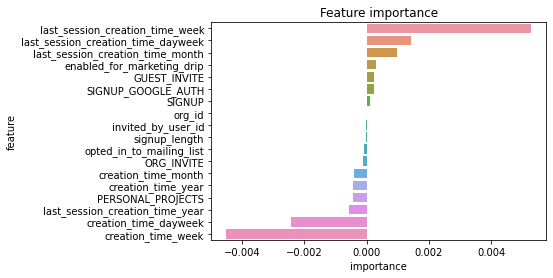

In [26]:
from sklearn.linear_model import LogisticRegression
y = df['adopted']
X = df.drop('adopted', axis =1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
columns = df.columns
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %35s, Score: %.5f' % (columns[i],v))

# plot feature importance
df_importance = pd.DataFrame()
df_importance["feature"] = X.columns
df_importance["importance"] = importance
sns.barplot(x="importance", y="feature", data=df_importance.sort_values(by="importance", ascending=False))
plt.title('Feature importance')

In [27]:
df_importance

,feature,importance
0,opted_in_to_mailing_list,-0.000087
1,enabled_for_marketing_drip,0.000296
2,org_id,0.000004
3,invited_by_user_id,-0.000003
4,creation_time_month,-0.000417
5,creation_time_year,-0.000449
6,creation_time_week,-0.004495
7,creation_time_dayweek,-0.002432
8,signup_length,-0.000018
9,last_session_creation_time_month,0.000980


In [28]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42)
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X, y)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.8769166666666667


In [29]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'Feature importance')

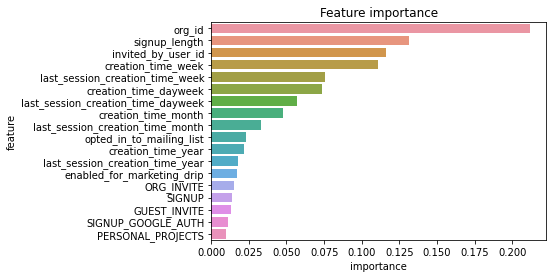

In [30]:
# plot feature importance
df_importance2 = pd.DataFrame()
df_importance2["feature"] = X.columns
df_importance2["importance"] = model.feature_importances_
sns.barplot(x="importance", y="feature", data=df_importance2.sort_values(by="importance", ascending=False))
plt.title('Feature importance')